<a href="https://colab.research.google.com/github/malihamostafa023-cmd/CNN/blob/main/CnnPretrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verify the dataset folders exist
import os

DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/chest_xray" # Moved to the next cell

for split in ["train", "val", "test"]:
    path = os.path.join(DATA_DIR, split)
    if not os.path.isdir(path):
        print(f"Missing: {path}")
    else:
        print(f"Found: {path}")

Mounted at /content/drive
Found: /content/drive/MyDrive/Colab Notebooks/chest_xray/train
Found: /content/drive/MyDrive/Colab Notebooks/chest_xray/val
Found: /content/drive/MyDrive/Colab Notebooks/chest_xray/test


In [3]:
import os

!ls "/content/drive/MyDrive/Colab Notebooks/chest_xray"


chest_xray  __MACOSX  test  train  val


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# ===============================
# Device setup
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# Data transforms
# ===============================
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                             [0.229, 0.224, 0.225]) # ImageNet std
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# ===============================
# Dataset and DataLoader
# ===============================
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/chest_xray"

# If you only have train + test, we'll use part of train as validation
splits = []
if os.path.isdir(os.path.join(DATA_DIR, "train")): splits.append("train")
if os.path.isdir(os.path.join(DATA_DIR, "val")): splits.append("val")
if os.path.isdir(os.path.join(DATA_DIR, "test")): splits.append("test")

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in splits}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in splits}

class_names = image_datasets[splits[0]].classes
print("Classes:", class_names)

# ===============================
# Load Pretrained ResNet18
# ===============================
model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(class_names))
)

model = model.to(device)

# ===============================
# Loss and optimizer
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)

# ===============================
# Training loop
# ===============================
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for phase in ["train", "val"] if "val" in dataloaders else ["train"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # save best model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), "best_model.pth")

    print("Training complete.")
    if "val" in dataloaders:
        print("Best val Acc: {:.4f}".format(best_acc))
    return model

model = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)

# ===============================
# Test evaluation
# ===============================
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

if "test" in dataloaders:
    test_model(model, dataloaders["test"])


Using device: cuda
Classes: ['NORMAL', 'PNEUMONIA']

Epoch 1/5
train Loss: 0.2521 Acc: 0.8951
val Loss: 0.3135 Acc: 0.8125

Epoch 2/5
train Loss: 0.1629 Acc: 0.9362
val Loss: 0.3999 Acc: 0.7500

Epoch 3/5
train Loss: 0.1607 Acc: 0.9377
val Loss: 0.6292 Acc: 0.6875

Epoch 4/5
train Loss: 0.1527 Acc: 0.9369
val Loss: 0.4108 Acc: 0.7500

Epoch 5/5
train Loss: 0.1403 Acc: 0.9433
val Loss: 0.3719 Acc: 0.7500
Training complete.
Best val Acc: 0.8125
Test Accuracy: 88.30%


Saving person1_virus_13.jpeg to person1_virus_13.jpeg


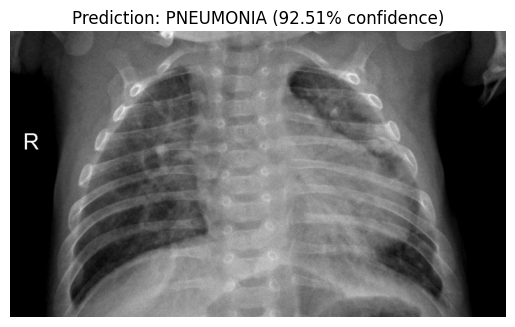

In [6]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# ===============================
# Load best saved model
# ===============================
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(class_names))
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.eval()

# ===============================
# Upload an image
# ===============================
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# ===============================
# Preprocess the image
# ===============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# ===============================
# Make prediction
# ===============================
with torch.no_grad():
    outputs = model(img_tensor)
    probs = torch.nn.functional.softmax(outputs, dim=1)  # confidence scores
    conf, preds = torch.max(probs, 1)
    predicted_class = class_names[preds.item()]
    confidence = conf.item() * 100  # percentage

# ===============================
# Show result
# ===============================
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {predicted_class} ({confidence:.2f}% confidence)")
plt.show()
